In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

act34 = pd.read_csv("/Users/jisoyun/Desktop/sparta_python/Healthcare/sparta_15/data/dailyActivity_merged.csv")

In [68]:
distance_columns = [col for col in act34.columns if 'Distance' in col]
for col in distance_columns:
    act34[col] = act34[col].round(3)

act34.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [69]:
act34.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

In [70]:
act34.isnull().sum()

Id                          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64

In [71]:
# 2-2. Calorie 그룹 추가
bins = [0, 500, 1000, 1500, 2000, 2500, float('inf')]
labels = ['500 이하', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500 이상']
act34['CalorieGroup'] = pd.cut(act34['Calories'], bins=bins, labels=labels, right=False)

print("✓ CalorieGroup 컬럼 추가 완료")
print(f"\n칼로리 그룹별 데이터 개수:")
print(act34['CalorieGroup'].value_counts().sort_index())

✓ CalorieGroup 컬럼 추가 완료

칼로리 그룹별 데이터 개수:
CalorieGroup
500 이하         9
500-1000       3
1000-1500     85
1500-2000    272
2000-2500    234
2500 이상      337
Name: count, dtype: int64


In [72]:
# 2-3. 날짜 형식 변환
act34['ActivityDate'] = pd.to_datetime(act34['ActivityDate'])

print("✓ ActivityDate를 datetime 형식으로 변환 완료")
print(f"날짜 범위: {act34['ActivityDate'].min()} ~ {act34['ActivityDate'].max()}")

✓ ActivityDate를 datetime 형식으로 변환 완료
날짜 범위: 2016-04-12 00:00:00 ~ 2016-05-12 00:00:00


In [73]:
# act34를 act341로 복사
act341 = act34.copy()
print(f"✓ act341 생성 완료 (행 개수: {len(act341)})")

✓ act341 생성 완료 (행 개수: 940)


In [74]:
# 3-1. 0값 확인
print("=== 0값 확인 ===")
numeric_cols = ['TotalSteps', 'TotalDistance', 'TrackerDistance',
                'LoggedActivitiesDistance', 'VeryActiveDistance',
                'ModeratelyActiveDistance', 'LightActiveDistance',
                'SedentaryActiveDistance', 'VeryActiveMinutes', 
                'FairlyActiveMinutes', 'LightlyActiveMinutes', 
                'SedentaryMinutes', 'Calories']

for col in numeric_cols:
    zero_count = (act341[col] == 0).sum()
    if zero_count > 0:
        print(f"{col}: {zero_count}개 ({zero_count/len(act341)*100:.1f}%)")

=== 0값 확인 ===
TotalSteps: 77개 (8.2%)
TotalDistance: 78개 (8.3%)
TrackerDistance: 78개 (8.3%)
LoggedActivitiesDistance: 908개 (96.6%)
VeryActiveDistance: 413개 (43.9%)
ModeratelyActiveDistance: 386개 (41.1%)
LightActiveDistance: 85개 (9.0%)
SedentaryActiveDistance: 858개 (91.3%)
VeryActiveMinutes: 409개 (43.5%)
FairlyActiveMinutes: 384개 (40.9%)
LightlyActiveMinutes: 84개 (8.9%)
SedentaryMinutes: 1개 (0.1%)
Calories: 4개 (0.4%)


In [75]:
# 3-2. TotalSteps가 0인 행 제거 (기기 미착용으로 추정)
print(f"\n처리 전 행 개수: {len(act341)}")

act341_cleaned = act341[act341['TotalSteps'] > 0].copy()

print(f"처리 후 행 개수: {len(act341_cleaned)}")
print(f"제거된 행 개수: {len(act341) - len(act341_cleaned)}")
print("✓ TotalSteps가 0인 행 제거 완료")


처리 전 행 개수: 940
처리 후 행 개수: 863
제거된 행 개수: 77
✓ TotalSteps가 0인 행 제거 완료


In [76]:
# 3-3. 이상치 확인 (IQR 방법)
print("\n=== IQR 방법 이상치 개수 ===")

outlier_cols = ['TotalSteps', 'TotalDistance', 'Calories', 'SedentaryMinutes']

for col in outlier_cols:
    Q1 = act341_cleaned[col].quantile(0.25)
    Q3 = act341_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = act341_cleaned[(act341_cleaned[col] < lower_bound) | (act341_cleaned[col] > upper_bound)]
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)}개 (하한: {lower_bound:.2f}, 상한: {upper_bound:.2f})")


=== IQR 방법 이상치 개수 ===
TotalSteps: 15개 (하한: -4331.25, 상한: 20346.75)
TotalDistance: 25개 (하한: -3.42, 상한: 14.70)
Calories: 9개 (하한: 390.75, 상한: 4296.75)
SedentaryMinutes: 3개 (하한: 20.25, 상한: 1890.25)


In [77]:
# 3-4. 이상치 제거
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# 이상치 제거할 주요 컬럼
outlier_cols = ['TotalSteps', 'TotalDistance', 'Calories', 'SedentaryMinutes']

print(f"이상치 제거 전: {len(act341_cleaned)}행")
act341_final = remove_outliers_iqr(act341_cleaned, outlier_cols)
print(f"이상치 제거 후: {len(act341_final)}행")
print(f"제거된 행: {len(act341_cleaned) - len(act341_final)}행")
print("✓ 이상치 제거 완료")

이상치 제거 전: 863행
이상치 제거 후: 829행
제거된 행: 34행
✓ 이상치 제거 완료


In [78]:
# 4-1. 최종 데이터 정보
print("=== 최종 데이터 정보 ===")
print(f"행 개수: {len(act341_final)}")
print(f"열 개수: {len(act341_final.columns)}")
print(f"\n데이터 타입:\n{act341_final.dtypes}")


=== 최종 데이터 정보 ===
행 개수: 829
열 개수: 16

데이터 타입:
Id                                   int64
ActivityDate                datetime64[ns]
TotalSteps                           int64
TotalDistance                      float64
TrackerDistance                    float64
LoggedActivitiesDistance           float64
VeryActiveDistance                 float64
ModeratelyActiveDistance           float64
LightActiveDistance                float64
SedentaryActiveDistance            float64
VeryActiveMinutes                    int64
FairlyActiveMinutes                  int64
LightlyActiveMinutes                 int64
SedentaryMinutes                     int64
Calories                             int64
CalorieGroup                      category
dtype: object


In [79]:
# 4-2. 주요 컬럼 통계
print("\n=== 주요 컬럼 기본 통계량 ===")
display(act341_final[['TotalSteps', 'TotalDistance', 'Calories', 'VeryActiveMinutes', 'SedentaryMinutes']].describe())




=== 주요 컬럼 기본 통계량 ===


,TotalSteps,TotalDistance,Calories,VeryActiveMinutes,SedentaryMinutes
count,829.000000,829.000000,829.000000,829.000000,829.000000
mean,7897.490953,5.590193,2314.392039,19.692400,959.956574
std,4088.120160,2.982852,636.839162,27.688628,275.912593
min,4.000000,0.000000,741.000000,0.000000,125.000000
25%,4790.000000,3.310000,1851.000000,0.000000,724.000000
50%,7851.000000,5.440000,2188.000000,6.000000,1020.000000
75%,10690.000000,7.670000,2786.000000,31.000000,1192.000000
max,20067.000000,14.380000,4163.000000,123.000000,1440.000000



=== 칼로리 그룹별 분포 ===
CalorieGroup
500 이하         0
500-1000       2
1000-1500     70
1500-2000    235
2000-2500    217
2500 이상      305
Name: count, dtype: int64


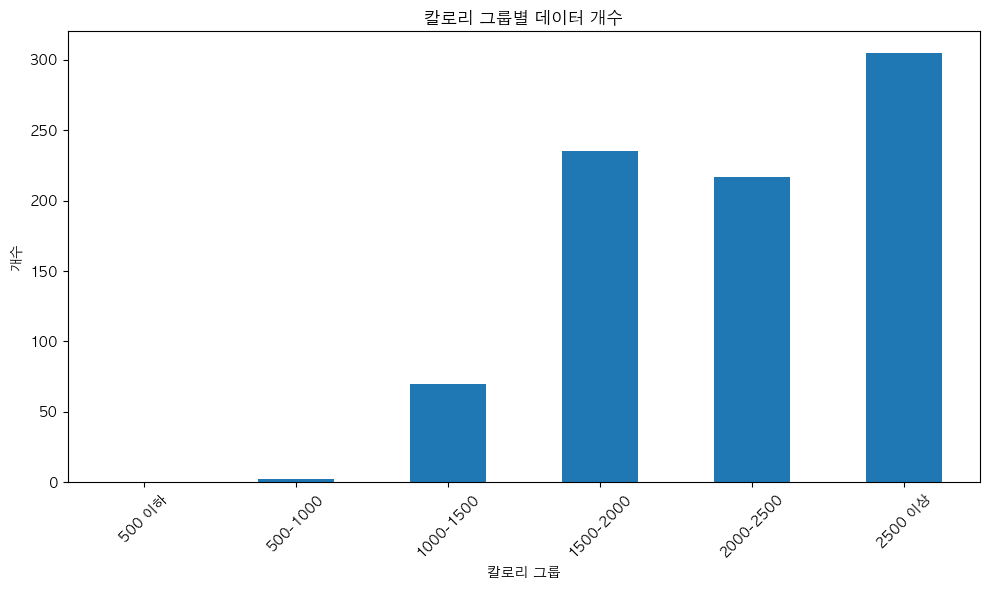

In [80]:
# 4-3. 칼로리 그룹별 분포
print("\n=== 칼로리 그룹별 분포 ===")
print(act341_final['CalorieGroup'].value_counts().sort_index())

# 시각화
plt.figure(figsize=(10, 6))
act341_final['CalorieGroup'].value_counts().sort_index().plot(kind='bar')
plt.title('칼로리 그룹별 데이터 개수')
plt.xlabel('칼로리 그룹')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [87]:
# 칼로리 그룹별 평균 계산
distance_cols = ['TotalSteps', 'TotalDistance', 'TrackerDistance', 
                'LoggedActivitiesDistance', 'VeryActiveDistance', 
                'ModeratelyActiveDistance', 'LightActiveDistance','SedentaryMinutes']

calorie_group_dis = act341_final.groupby('CalorieGroup', observed=True)[distance_cols].mean().round(3)
calorie_group_dis


,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryMinutes
CalorieGroup,,,,,,,,
500-1000,3354.000,2.205,2.205,0.000,0.290,0.325,1.585,174.500
1000-1500,3501.857,2.312,2.312,0.000,0.167,0.124,2.017,990.643
1500-2000,6785.519,4.522,4.522,0.000,0.771,0.615,3.122,967.630
2000-2500,7590.982,5.178,5.168,0.046,1.035,0.504,3.584,956.507
2500 이상,10010.957,7.481,7.443,0.293,2.146,0.790,4.383,954.607


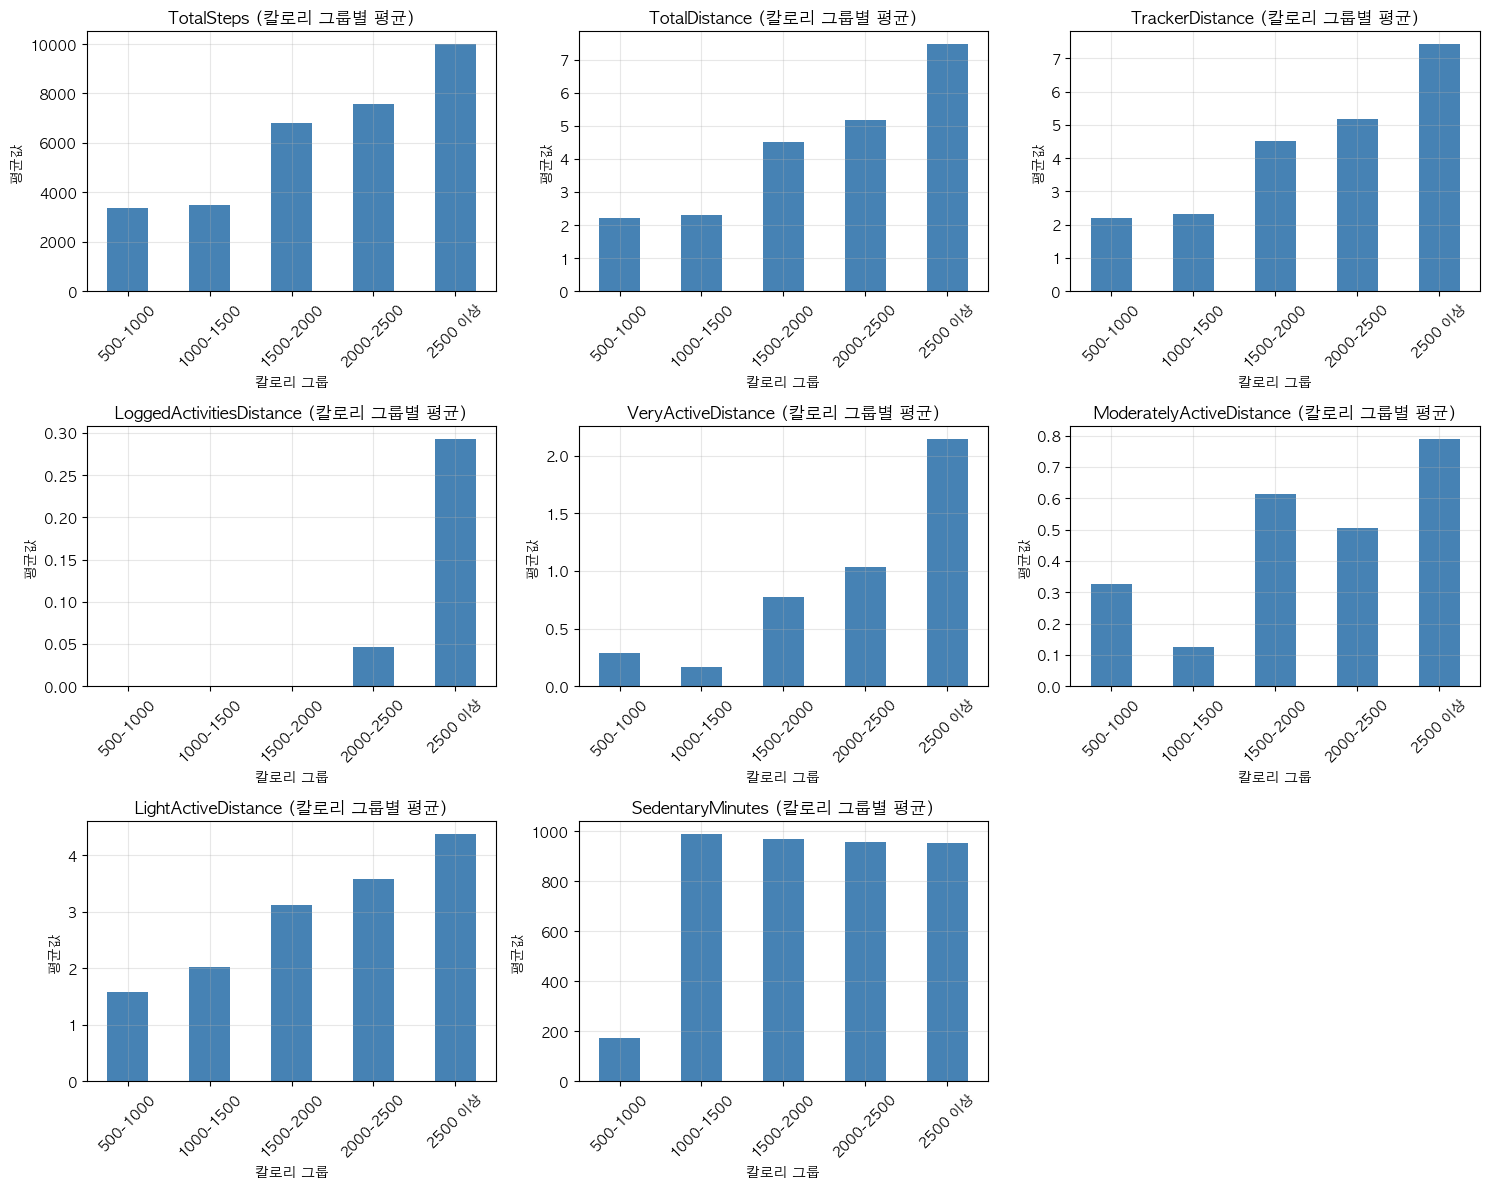

In [88]:
# 시각화 - 각 컬럼별로 그래프
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(distance_cols):
    calorie_group_dis[col].plot(kind='bar', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)')
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균값')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

# 남은 subplot 제거
for idx in range(len(distance_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [89]:
# 데이터프레임으로 보기 좋게 출력
print("\n=== 칼로리 그룹별 상세 통계 ===")
display(calorie_group_dis)

# 각 그룹의 데이터 개수도 함께 표시
print("\n=== 각 그룹의 데이터 개수 ===")
print(act341_final['CalorieGroup'].value_counts().sort_index())


=== 칼로리 그룹별 상세 통계 ===


,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryMinutes
CalorieGroup,,,,,,,,
500-1000,3354.000,2.205,2.205,0.000,0.290,0.325,1.585,174.500
1000-1500,3501.857,2.312,2.312,0.000,0.167,0.124,2.017,990.643
1500-2000,6785.519,4.522,4.522,0.000,0.771,0.615,3.122,967.630
2000-2500,7590.982,5.178,5.168,0.046,1.035,0.504,3.584,956.507
2500 이상,10010.957,7.481,7.443,0.293,2.146,0.790,4.383,954.607



=== 각 그룹의 데이터 개수 ===
CalorieGroup
500 이하         0
500-1000       2
1000-1500     70
1500-2000    235
2000-2500    217
2500 이상      305
Name: count, dtype: int64


In [90]:
# 칼로리 그룹별 활동 시간 평균 계산
activity_cols = ['VeryActiveMinutes', 'FairlyActiveMinutes', 
                'LightlyActiveMinutes', 'SedentaryMinutes']

calorie_group_min = act341_final.groupby('CalorieGroup', observed=True)[activity_cols].mean().round(3)
calorie_group_min

,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
500-1000,4.000,7.000,76.500,174.500
1000-1500,2.286,2.686,128.657,990.643
1500-2000,10.464,13.519,205.068,967.630
2000-2500,14.286,10.935,229.470,956.507
2500 이상,34.748,20.426,220.679,954.607


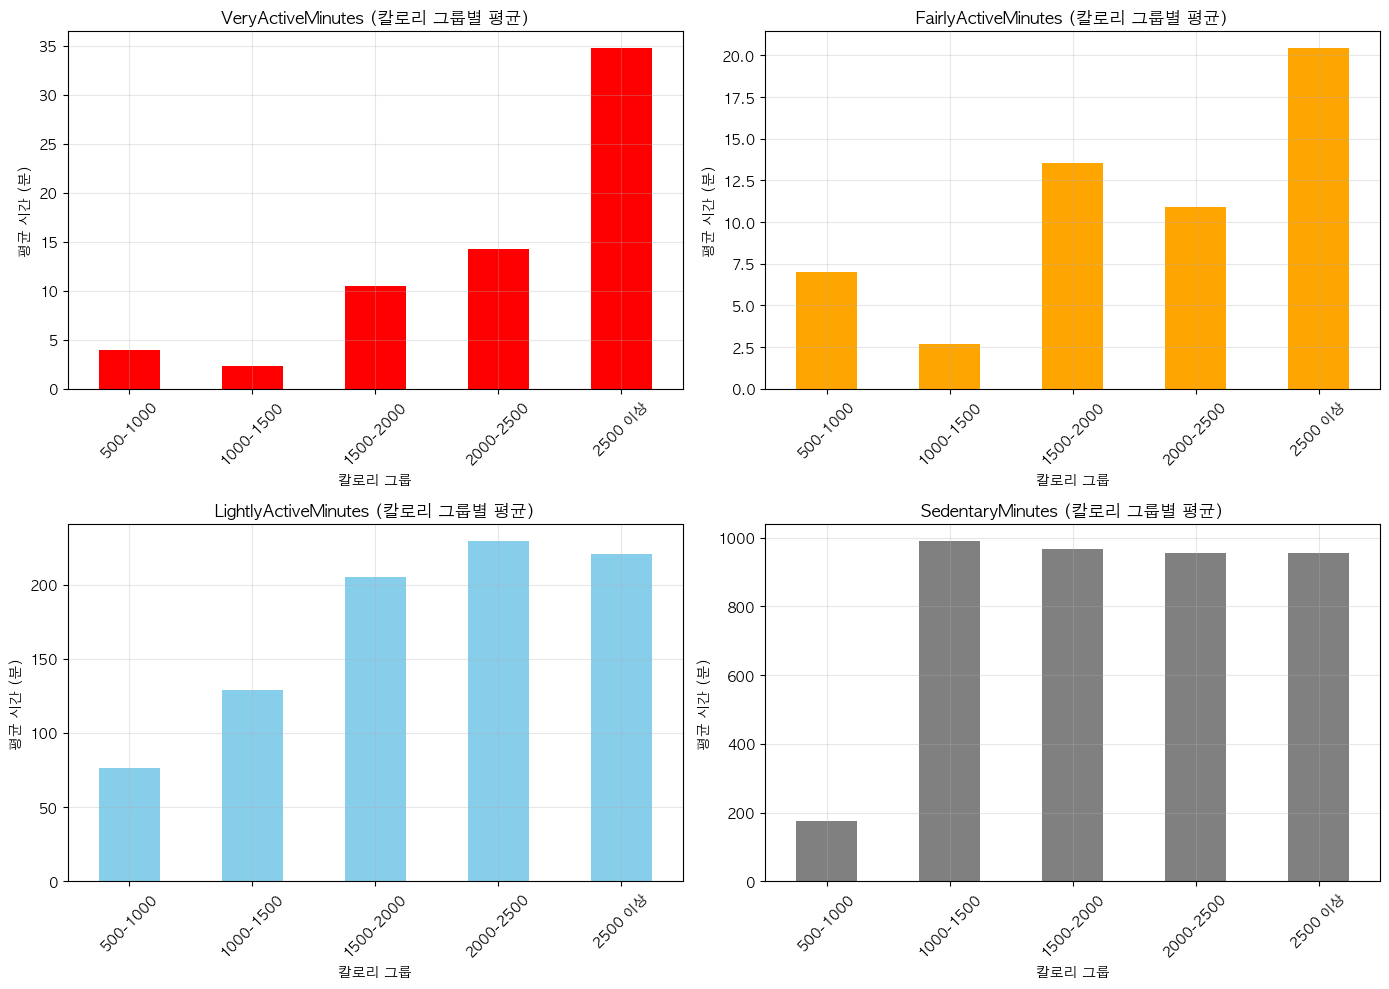

In [91]:
# 시각화 - 각 활동 시간별로 그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['red', 'orange', 'skyblue', 'gray']

for idx, col in enumerate(activity_cols):
    calorie_group_min[col].plot(kind='bar', ax=axes[idx], color=colors[idx])
    axes[idx].set_title(f'{col} (칼로리 그룹별 평균)', fontsize=12)
    axes[idx].set_xlabel('칼로리 그룹')
    axes[idx].set_ylabel('평균 시간 (분)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

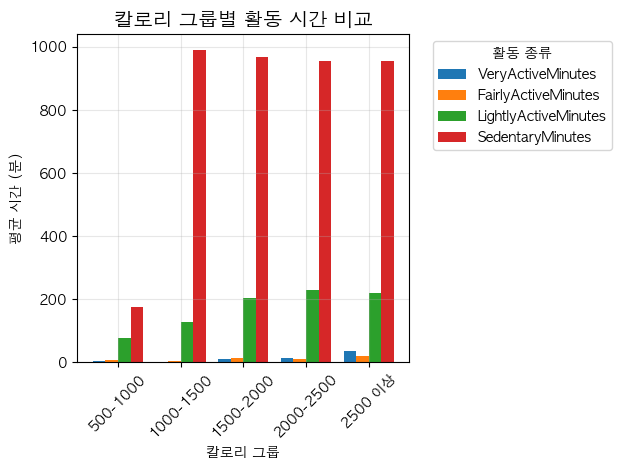

In [92]:
# 모든 활동 시간을 하나의 그래프로 비교
plt.figure(figsize=(12, 6))
calorie_group_min.plot(kind='bar', width=0.8)
plt.title('칼로리 그룹별 활동 시간 비교', fontsize=14)
plt.xlabel('칼로리 그룹')
plt.ylabel('평균 시간 (분)')
plt.legend(title='활동 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [94]:
# 데이터프레임으로 보기 좋게 출력
print("\n=== 칼로리 그룹별 활동 시간 상세 통계 ===")
display(calorie_group_min)

# 총 활동 시간도 계산
calorie_group_min['TotalActiveMinutes'] = (
    calorie_group_min['VeryActiveMinutes'] + 
    calorie_group_min['FairlyActiveMinutes'] +
    calorie_group_min['LightlyActiveMinutes']
).round(3)

print("\n=== 총 활동 시간 포함 ===")
display(calorie_group_min)


=== 칼로리 그룹별 활동 시간 상세 통계 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes
CalorieGroup,,,,
500-1000,4.000,7.000,76.500,174.500
1000-1500,2.286,2.686,128.657,990.643
1500-2000,10.464,13.519,205.068,967.630
2000-2500,14.286,10.935,229.470,956.507
2500 이상,34.748,20.426,220.679,954.607



=== 총 활동 시간 포함 ===


,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,TotalActiveMinutes
CalorieGroup,,,,,
500-1000,4.000,7.000,76.500,174.500,87.500
1000-1500,2.286,2.686,128.657,990.643,133.629
1500-2000,10.464,13.519,205.068,967.630,229.051
2000-2500,14.286,10.935,229.470,956.507,254.691
2500 이상,34.748,20.426,220.679,954.607,275.853


In [101]:
# act341_cleaned에서 파생 변수 생성 (0값 제거 후, 이상치 제거 전)
# 1. 평균 속도 (km/h) - 총 거리 / 총 활동 시간
act341_cleaned['TotalActiveMinutes'] = (act341_cleaned['VeryActiveMinutes'] + 
                                        act341_cleaned['FairlyActiveMinutes'] + 
                                        act341_cleaned['LightlyActiveMinutes'])
act341_cleaned['AvgSpeed_kmh'] = (act341_cleaned['TotalDistance'] / 
                                  (act341_cleaned['TotalActiveMinutes'] / 60)).round(3)

# 2. 평균 페이스 (분/km) - 총 활동 시간 / 총 거리
act341_cleaned['AvgPace_min_per_km'] = (act341_cleaned['TotalActiveMinutes'] / 
                                        act341_cleaned['TotalDistance']).round(3)

# 3. 보폭 (미터) - 총 거리 / 총 걸음 수
act341_cleaned['AvgStride_m'] = ((act341_cleaned['TotalDistance'] * 1000) / 
                                 act341_cleaned['TotalSteps']).round(3)

# 4. 활동 강도 비율
act341_cleaned['VeryActiveRatio'] = (act341_cleaned['VeryActiveMinutes'] / 
                                     act341_cleaned['TotalActiveMinutes']).round(3)
act341_cleaned['LightActiveRatio'] = (act341_cleaned['LightlyActiveMinutes'] / 
                                      act341_cleaned['TotalActiveMinutes']).round(3)

# 5. 칼로리 효율 (칼로리/km)
act341_cleaned['CaloriesPerKm'] = (act341_cleaned['Calories'] / 
                                   act341_cleaned['TotalDistance']).round(3)

# 0으로 나누는 경우 inf나 nan 처리
act341_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

print("✓ 파생 변수 생성 완료")
print(f"생성된 변수: TotalActiveMinutes, AvgSpeed_kmh, AvgPace_min_per_km, AvgStride_m, VeryActiveRatio, LightActiveRatio, CaloriesPerKm")



✓ 파생 변수 생성 완료
생성된 변수: TotalActiveMinutes, AvgSpeed_kmh, AvgPace_min_per_km, AvgStride_m, VeryActiveRatio, LightActiveRatio, CaloriesPerKm


In [102]:
# 이제 이상치 제거 (파생 변수 포함)
def remove_outliers_iqr(df, columns):
    """IQR 방법으로 이상치 제거"""
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# 이상치 제거할 주요 컬럼 (기본 + 파생 변수)
outlier_cols = ['TotalSteps', 'TotalDistance', 'Calories', 'SedentaryMinutes',
                'AvgSpeed_kmh', 'AvgPace_min_per_km', 'AvgStride_m']

print(f"이상치 제거 전: {len(act341_cleaned)}행")
act341_final = remove_outliers_iqr(act341_cleaned, outlier_cols)
print(f"이상치 제거 후: {len(act341_final)}행")
print(f"제거된 행: {len(act341_cleaned) - len(act341_final)}행")
print("✓ 이상치 제거 완료")

이상치 제거 전: 863행
이상치 제거 후: 789행
제거된 행: 74행
✓ 이상치 제거 완료


In [103]:
# 이제 칼로리 그룹별 파생 변수 평균 계산
derived_cols = ['TotalActiveMinutes', 'AvgSpeed_kmh', 'AvgPace_min_per_km', 
                'AvgStride_m', 'VeryActiveRatio', 'LightActiveRatio', 'CaloriesPerKm']

calorie_group_derived = act341_final.groupby('CalorieGroup', observed=True)[derived_cols].mean().round(3)

print("=== 칼로리 그룹별 파생 변수 평균 ===")
display(calorie_group_derived)

=== 칼로리 그룹별 파생 변수 평균 ===


,TotalActiveMinutes,AvgSpeed_kmh,AvgPace_min_per_km,AvgStride_m,VeryActiveRatio,LightActiveRatio,CaloriesPerKm
CalorieGroup,,,,,,,
500-1000,87.500,1.616,39.036,0.658,0.064,0.852,377.398
1000-1500,141.391,1.023,66.890,0.660,0.013,0.972,1770.996
1500-2000,234.908,1.181,57.714,0.667,0.046,0.895,885.969
2000-2500,262.215,1.220,54.913,0.686,0.056,0.900,955.621
2500 이상,283.748,1.566,41.518,0.748,0.119,0.806,476.308


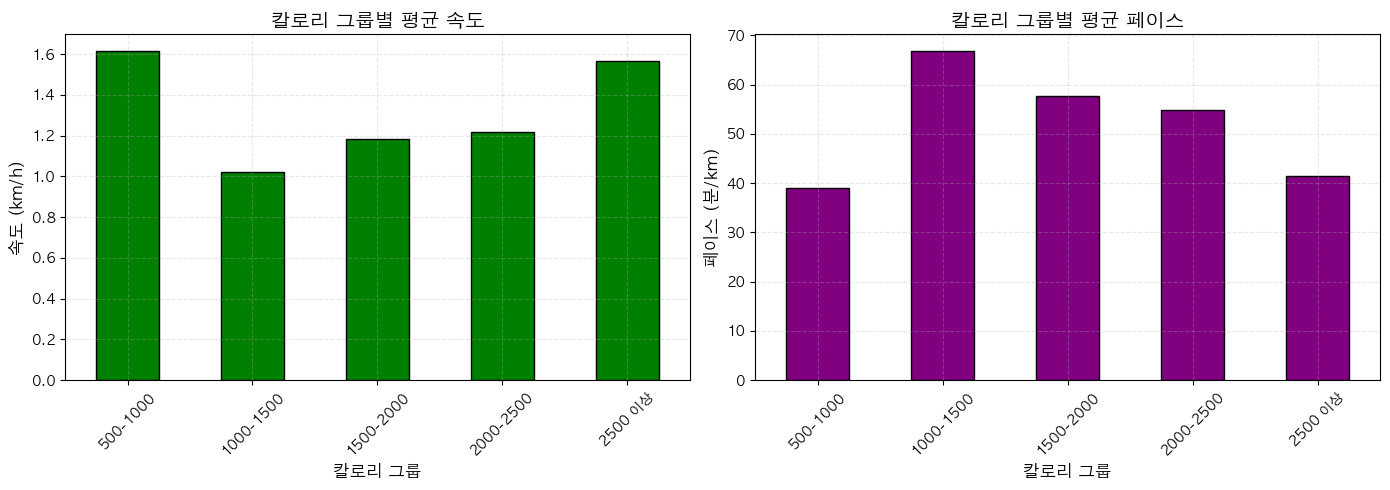

In [104]:
# 1. 속도와 페이스 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 속도
calorie_group_derived['AvgSpeed_kmh'].plot(kind='bar', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 속도', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('속도 (km/h)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 평균 페이스
calorie_group_derived['AvgPace_min_per_km'].plot(kind='bar', ax=axes[1], color='purple', edgecolor='black')
axes[1].set_title('칼로리 그룹별 평균 페이스', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('페이스 (분/km)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

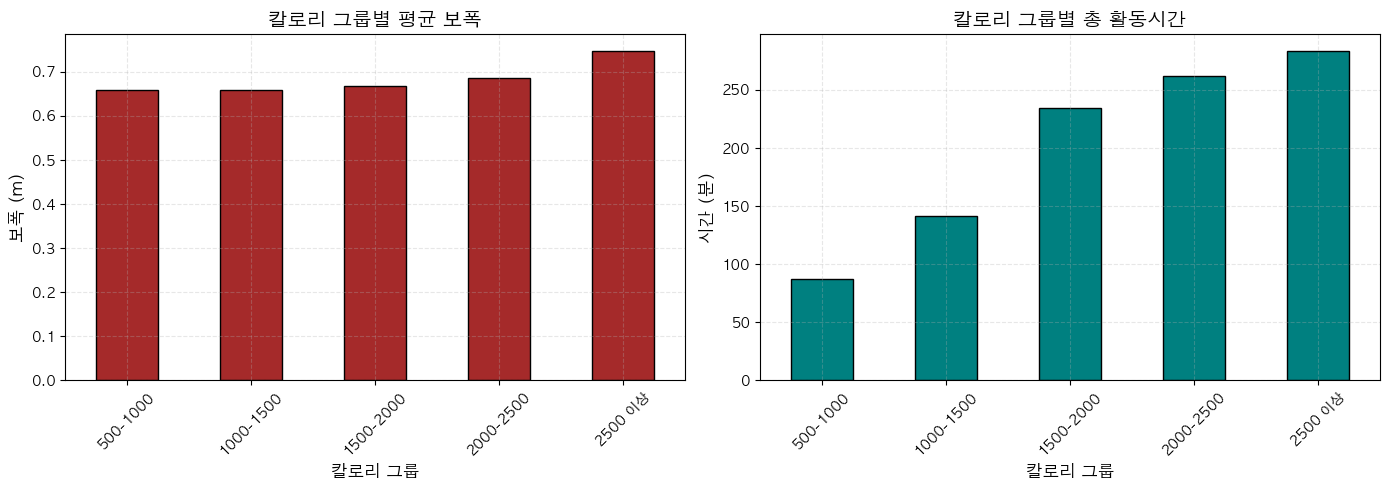

In [105]:
# 2. 보폭과 총 활동시간
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 보폭
calorie_group_derived['AvgStride_m'].plot(kind='bar', ax=axes[0], color='brown', edgecolor='black')
axes[0].set_title('칼로리 그룹별 평균 보폭', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('보폭 (m)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# 총 활동시간
calorie_group_derived['TotalActiveMinutes'].plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_title('칼로리 그룹별 총 활동시간', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('시간 (분)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

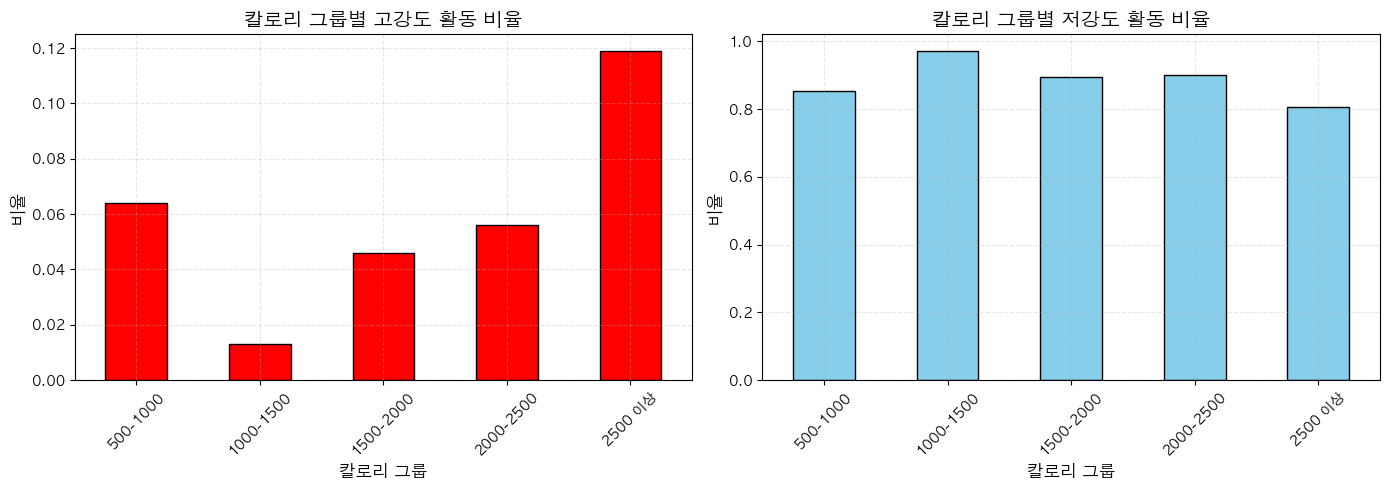

In [106]:
# 3. 활동 강도 비율 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Very Active 비율
calorie_group_derived['VeryActiveRatio'].plot(kind='bar', ax=axes[0], color='red', edgecolor='black')
axes[0].set_title('칼로리 그룹별 고강도 활동 비율', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('비율', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Light Active 비율
calorie_group_derived['LightActiveRatio'].plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('칼로리 그룹별 저강도 활동 비율', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('비율', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

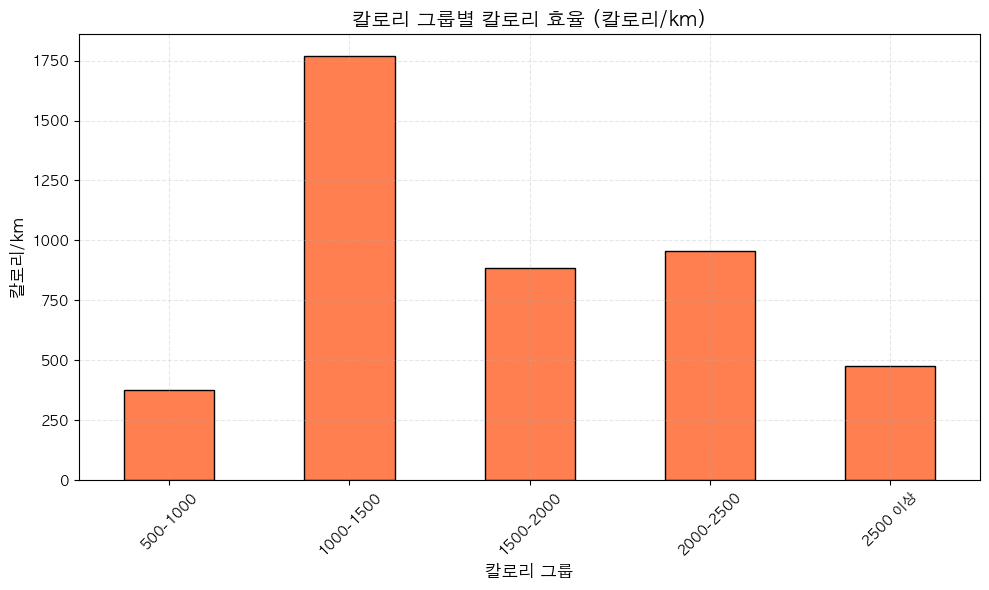

In [107]:
# 4. 칼로리 효율
plt.figure(figsize=(10, 6))
calorie_group_derived['CaloriesPerKm'].plot(kind='bar', color='coral', edgecolor='black')
plt.title('칼로리 그룹별 칼로리 효율 (칼로리/km)', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('칼로리/km', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

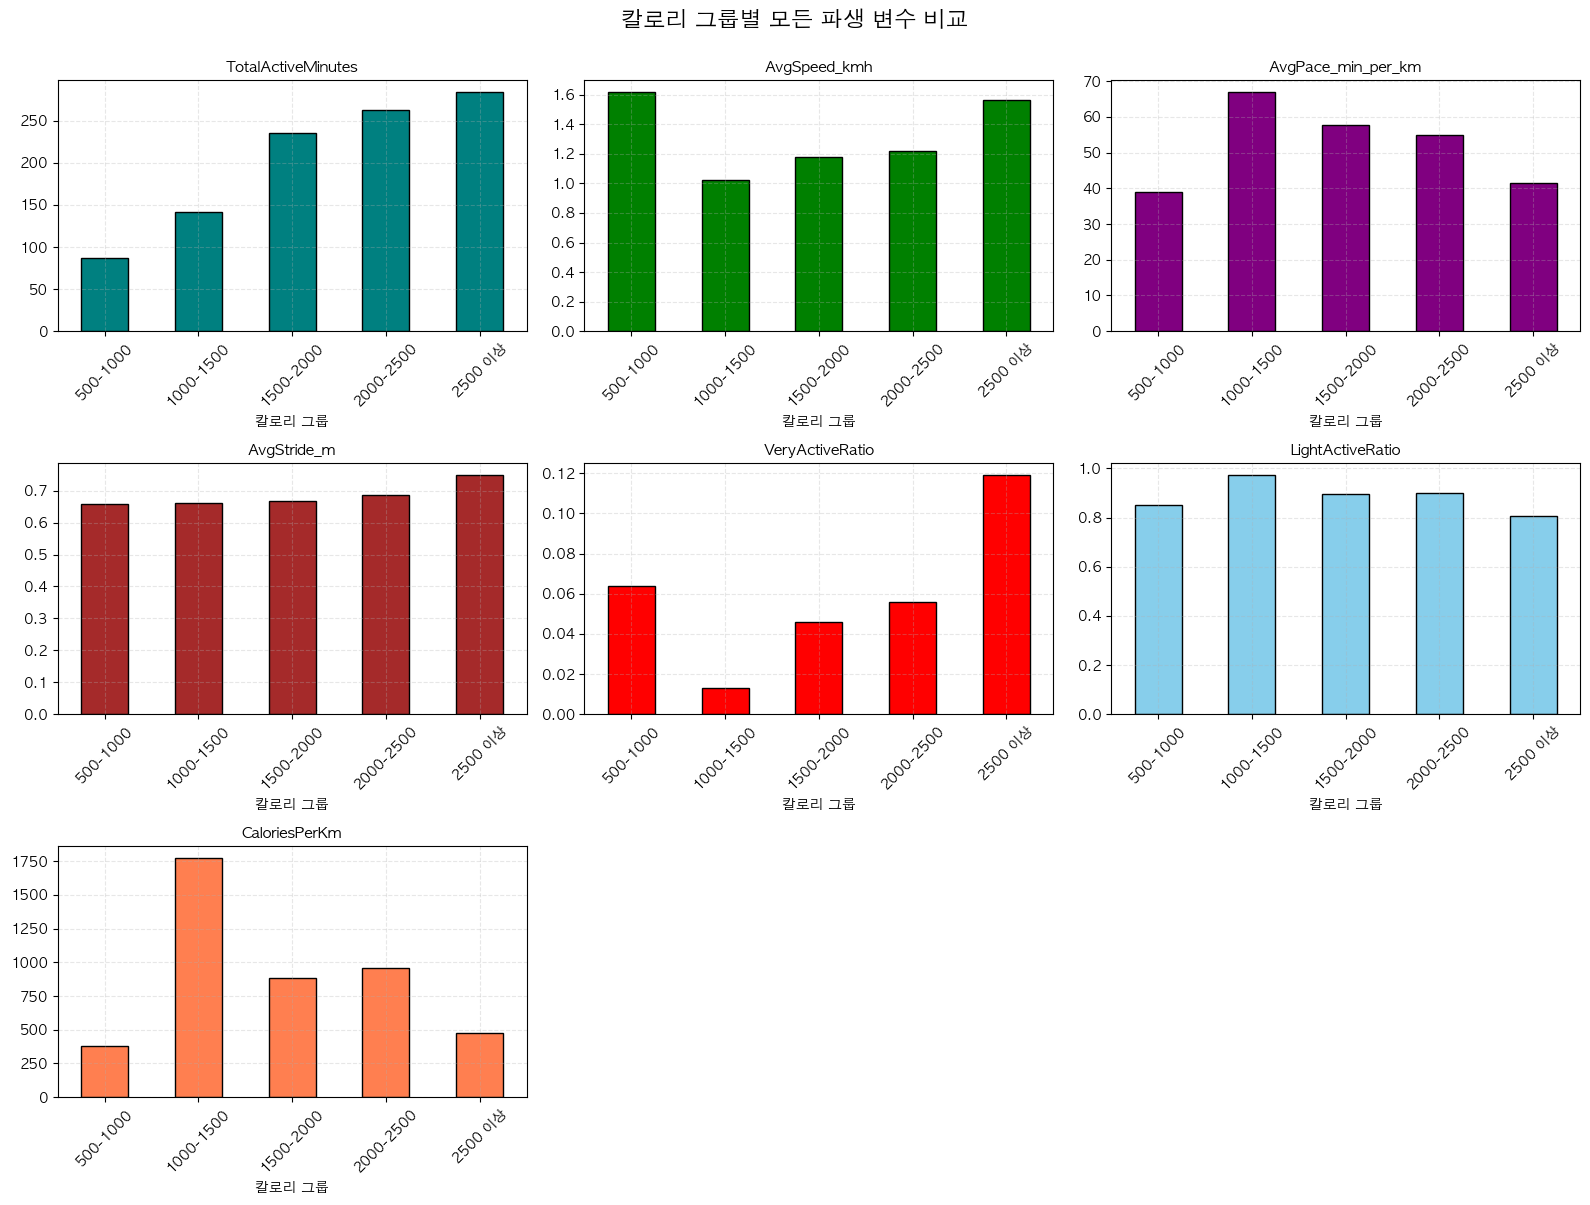

In [108]:
# 5. 모든 파생 변수 한번에 비교 (서브플롯)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

colors = ['teal', 'green', 'purple', 'brown', 'red', 'skyblue', 'coral']

for idx, col in enumerate(derived_cols):
    calorie_group_derived[col].plot(kind='bar', ax=axes[idx], 
                                    color=colors[idx], edgecolor='black')
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('칼로리 그룹', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

# 남은 subplot 제거
for idx in range(len(derived_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('칼로리 그룹별 모든 파생 변수 비교', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

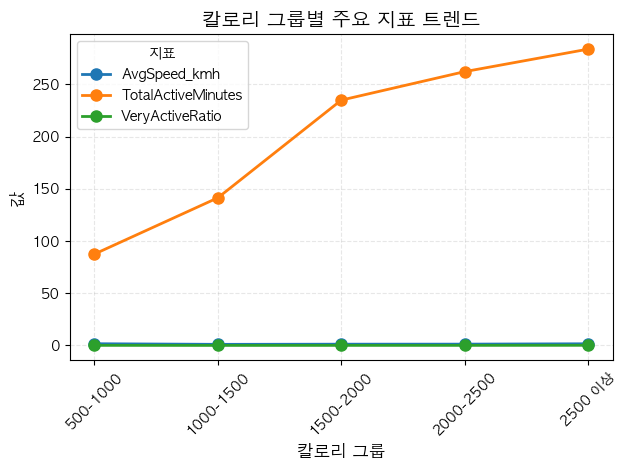

In [109]:
# 6. 라인 차트로 트렌드 확인
plt.figure(figsize=(12, 6))
calorie_group_derived[['AvgSpeed_kmh', 'TotalActiveMinutes', 'VeryActiveRatio']].plot(
    kind='line', marker='o', linewidth=2, markersize=8
)
plt.title('칼로리 그룹별 주요 지표 트렌드', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('값', fontsize=12)
plt.legend(title='지표', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(len(calorie_group_derived)), calorie_group_derived.index, rotation=45)
plt.tight_layout()
plt.show()

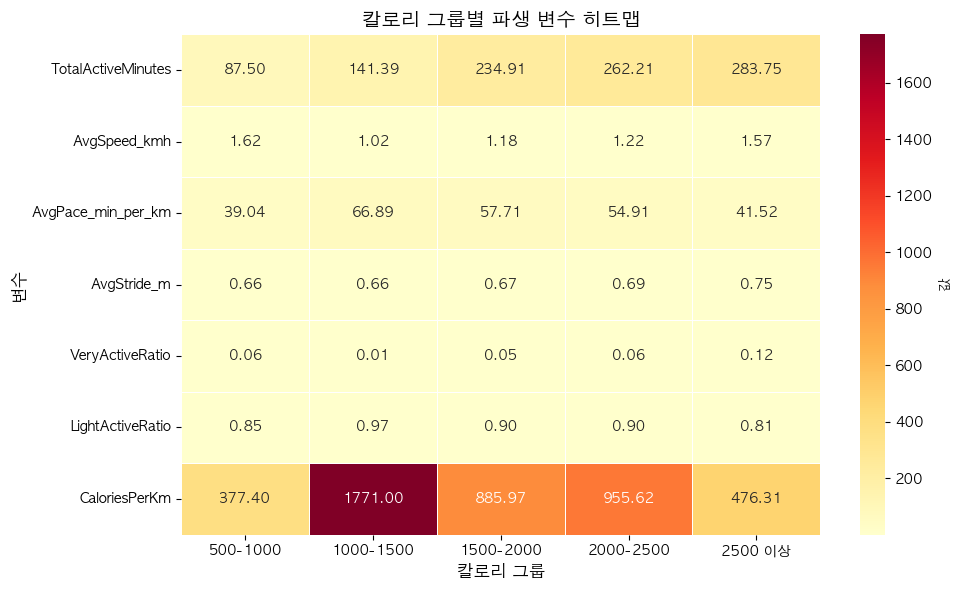

In [110]:
# 7. 히트맵으로 모든 변수 한눈에 보기
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(calorie_group_derived.T, annot=True, fmt='.2f', 
            cmap='YlOrRd', cbar_kws={'label': '값'}, linewidths=0.5)
plt.title('칼로리 그룹별 파생 변수 히트맵', fontsize=14, fontweight='bold')
plt.xlabel('칼로리 그룹', fontsize=12)
plt.ylabel('변수', fontsize=12)
plt.tight_layout()
plt.show()

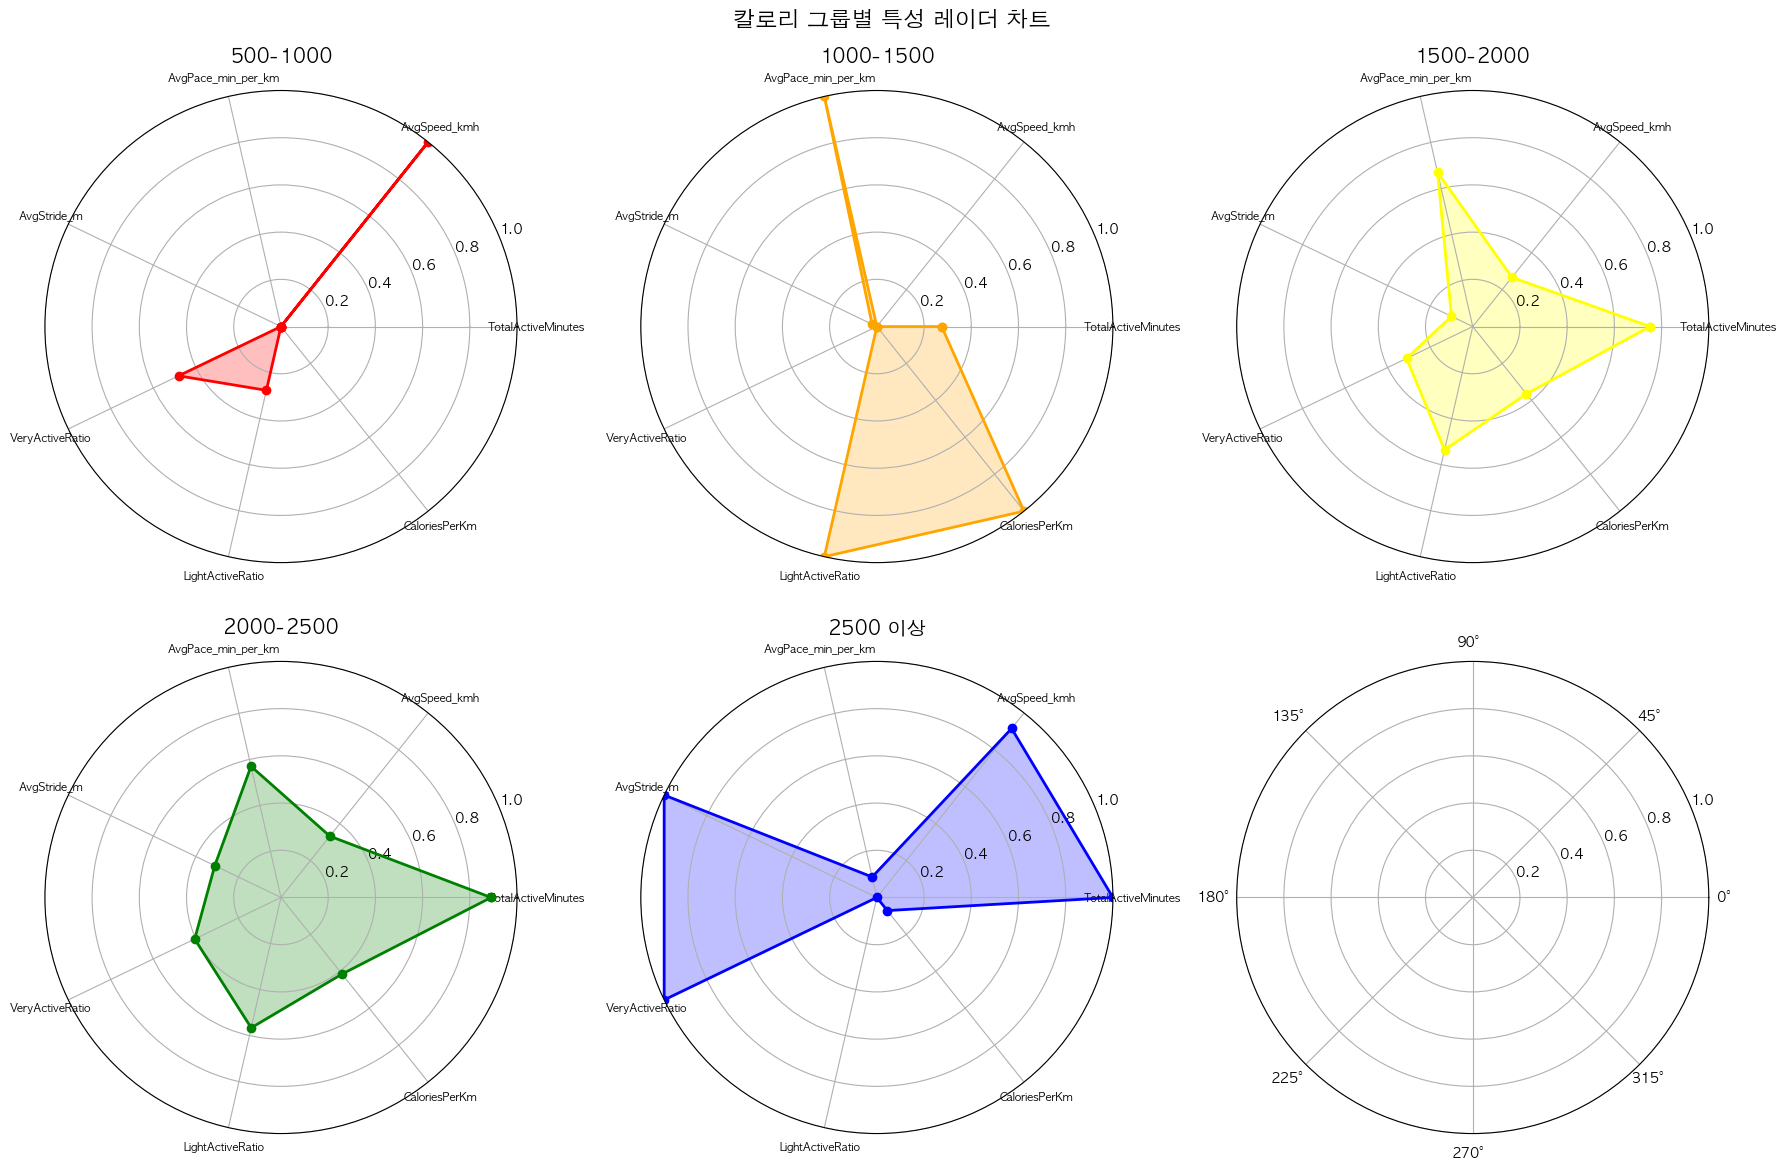

In [112]:
# 8. 정규화된 비교 (모든 변수를 같은 스케일로)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
calorie_group_derived_normalized = pd.DataFrame(
    scaler.fit_transform(calorie_group_derived),
    index=calorie_group_derived.index,
    columns=calorie_group_derived.columns
)

# 1. 레이더 차트 (각 칼로리 그룹의 특성을 한눈에)
import numpy as np
from math import pi

# 데이터 준비
categories = list(calorie_group_derived_normalized.columns)
N = len(categories)

# 각도 계산
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for idx, (group, color) in enumerate(zip(calorie_group_derived_normalized.index, colors)):
    ax = axes[idx]
    
    values = calorie_group_derived_normalized.loc[group].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=group, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 1)
    ax.set_title(f'{group}', size=14, fontweight='bold', pad=20)
    ax.grid(True)

plt.suptitle('칼로리 그룹별 특성 레이더 차트', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

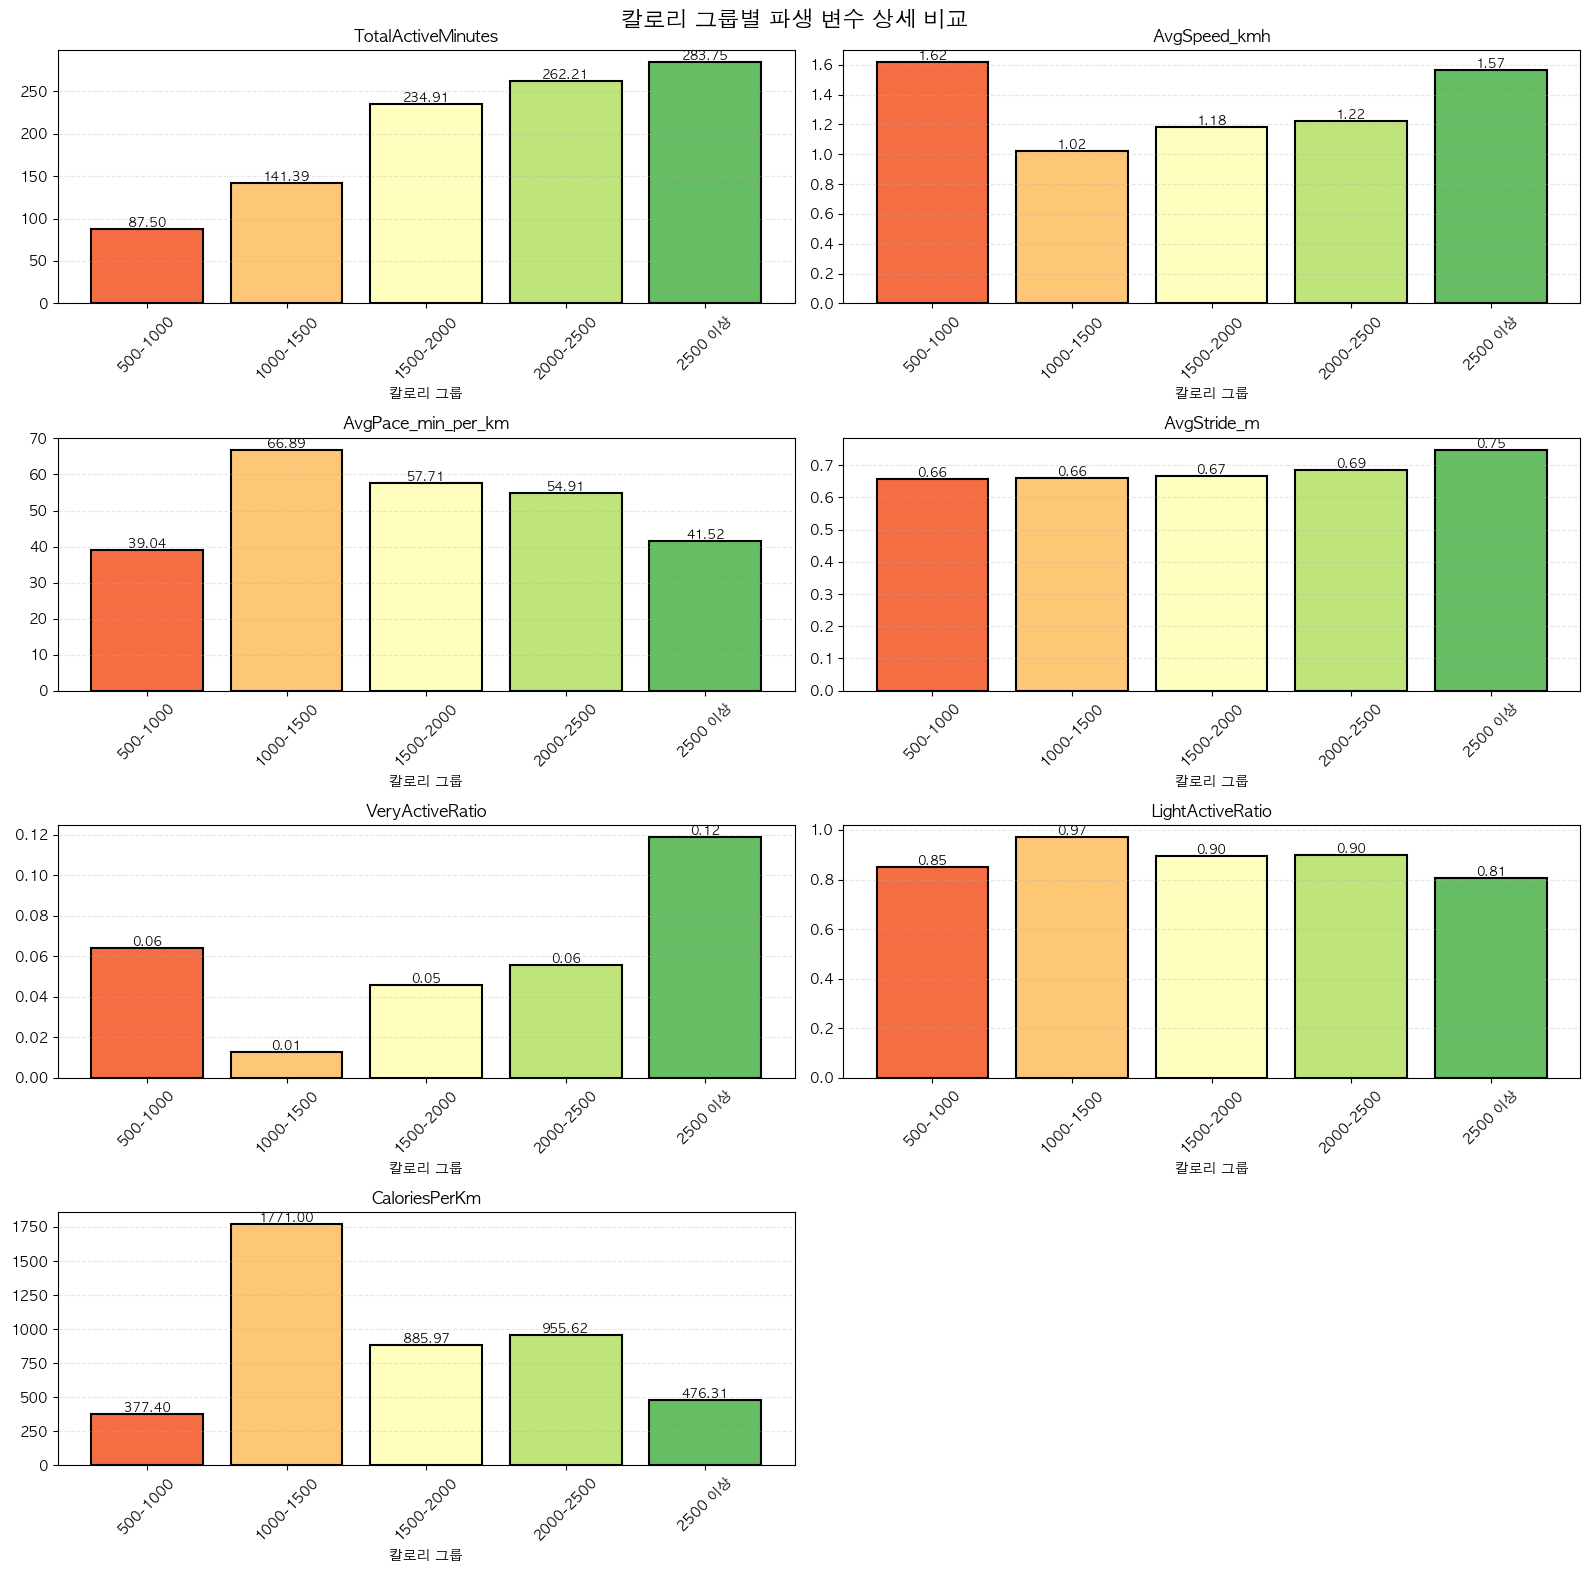

In [113]:
# 2. 변수별로 개별 막대 그래프 (비교하기 쉽게)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(calorie_group_derived)))

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    bars = ax.bar(calorie_group_derived.index, 
                  calorie_group_derived[col], 
                  color=colors_gradient, 
                  edgecolor='black',
                  linewidth=1.5)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 상세 비교', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

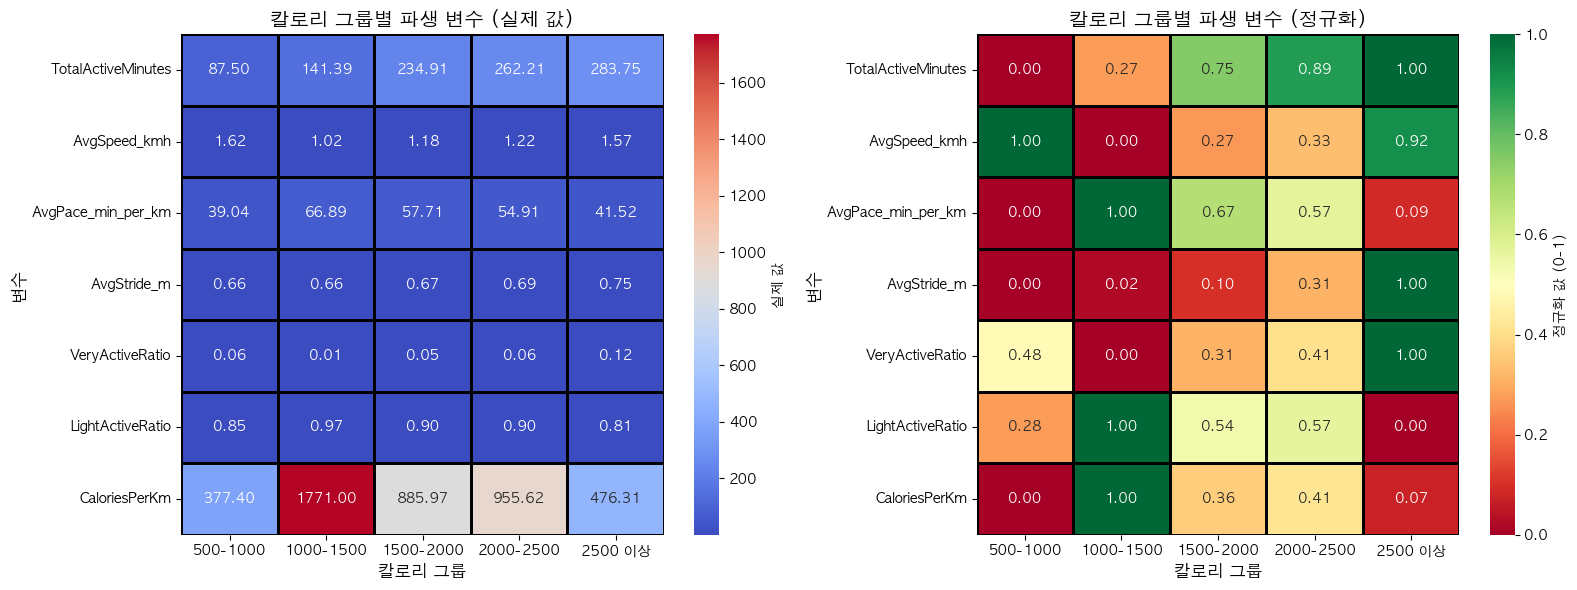

In [114]:
# 3. 히트맵 (더 명확한 색상)
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 원본 값 히트맵
sns.heatmap(calorie_group_derived.T, annot=True, fmt='.2f', 
            cmap='coolwarm', cbar_kws={'label': '실제 값'}, 
            linewidths=1, linecolor='black', ax=axes[0])
axes[0].set_title('칼로리 그룹별 파생 변수 (실제 값)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('칼로리 그룹', fontsize=12)
axes[0].set_ylabel('변수', fontsize=12)

# 정규화된 값 히트맵
sns.heatmap(calorie_group_derived_normalized.T, annot=True, fmt='.2f', 
            cmap='RdYlGn', cbar_kws={'label': '정규화 값 (0-1)'}, 
            linewidths=1, linecolor='black', ax=axes[1],
            vmin=0, vmax=1)
axes[1].set_title('칼로리 그룹별 파생 변수 (정규화)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('칼로리 그룹', fontsize=12)
axes[1].set_ylabel('변수', fontsize=12)

plt.tight_layout()
plt.show()

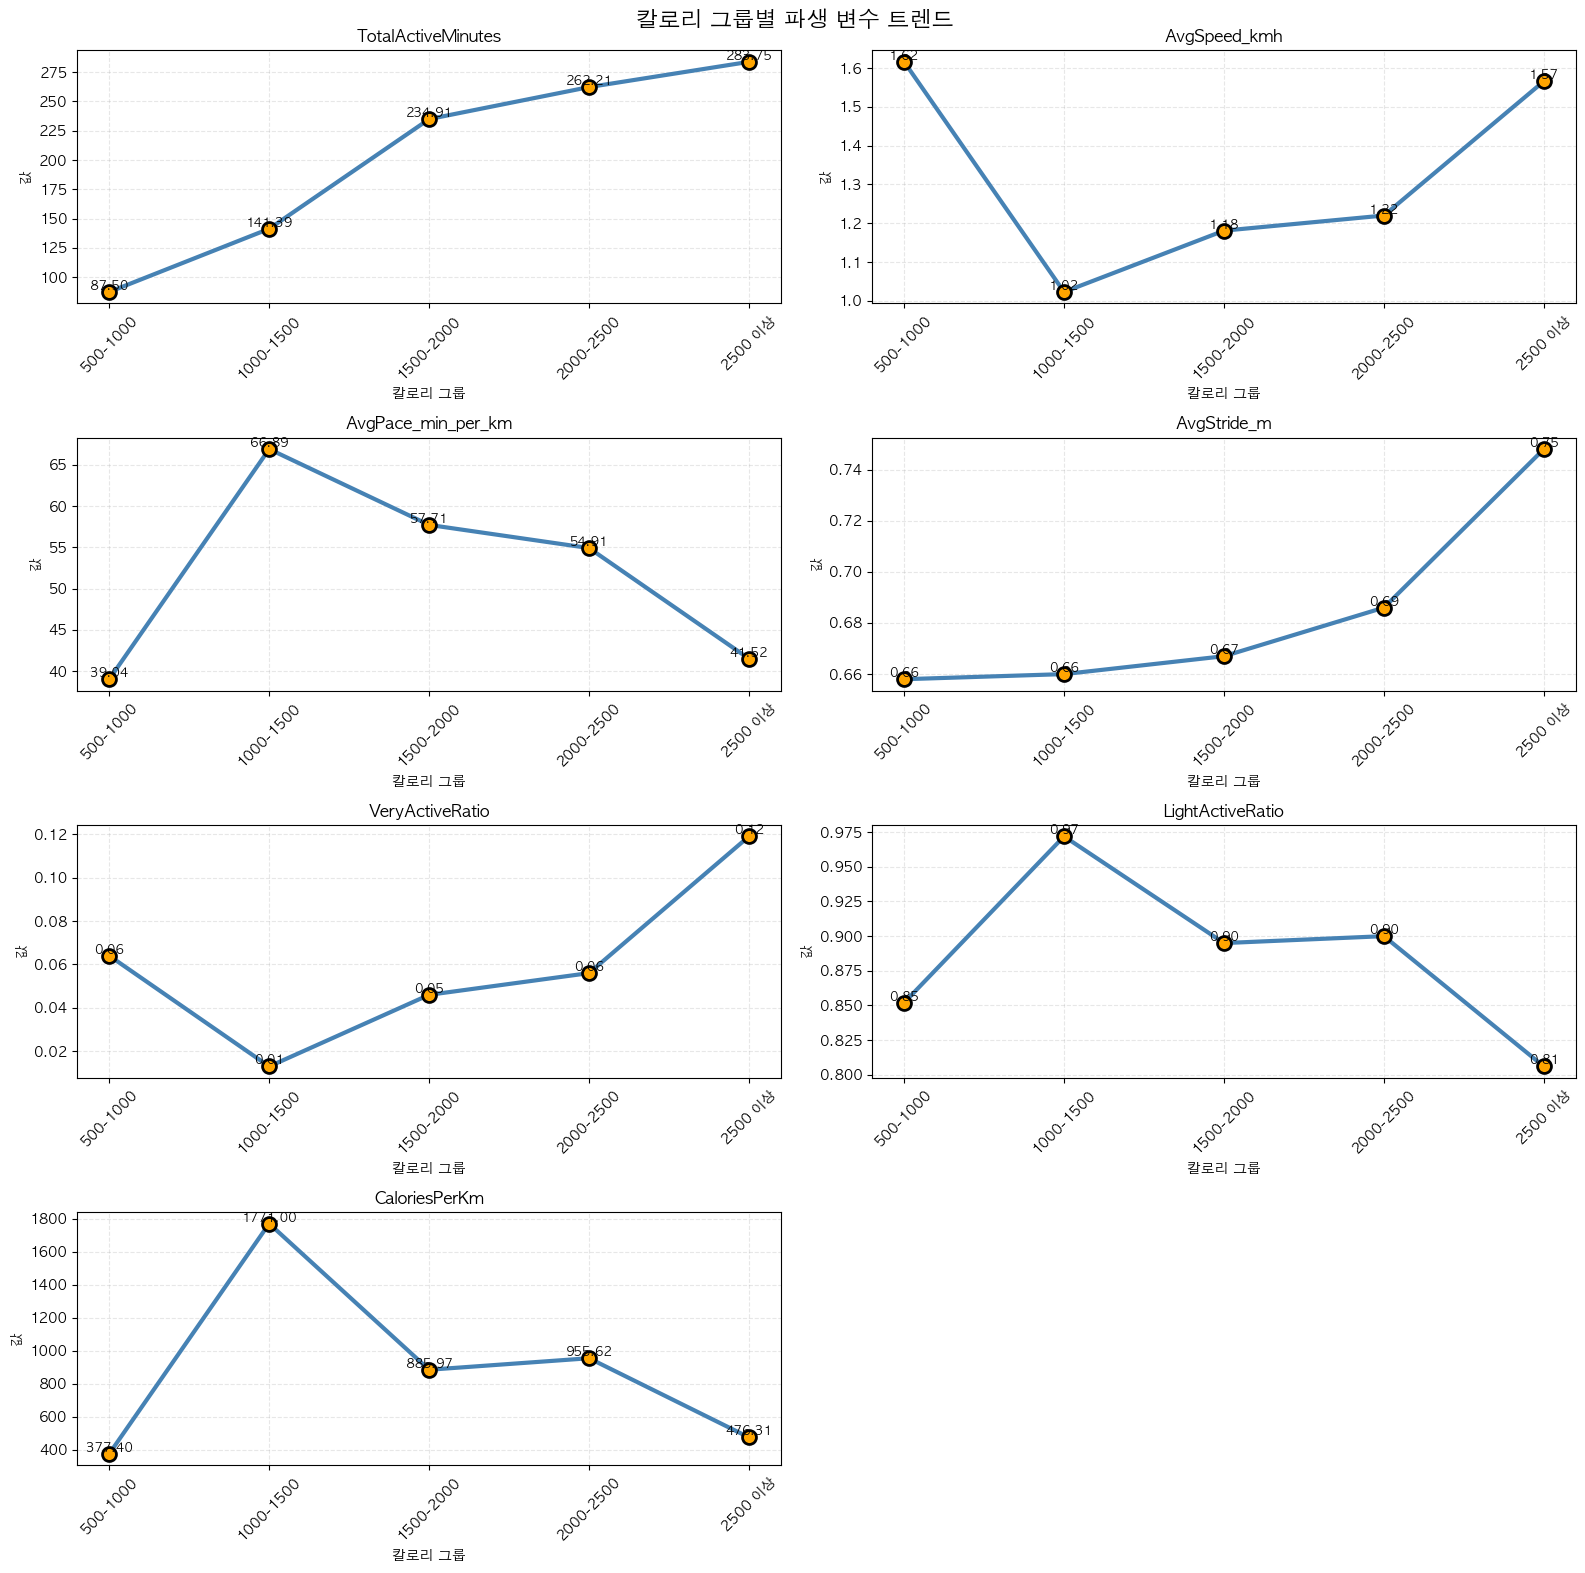

In [115]:
# 4. 라인 차트 (트렌드 파악)
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

markers = ['o', 's', '^', 'D', 'v', '<', '>']

for idx, col in enumerate(derived_cols):
    ax = axes[idx]
    ax.plot(range(len(calorie_group_derived)), 
            calorie_group_derived[col], 
            marker='o', linewidth=3, markersize=10,
            color='steelblue', markerfacecolor='orange', 
            markeredgewidth=2, markeredgecolor='black')
    
    # 값 표시
    for i, (x, y) in enumerate(zip(range(len(calorie_group_derived)), 
                                    calorie_group_derived[col])):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')
    
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('칼로리 그룹', fontsize=10)
    ax.set_ylabel('값', fontsize=10)
    ax.set_xticks(range(len(calorie_group_derived)))
    ax.set_xticklabels(calorie_group_derived.index, rotation=45)
    ax.grid(True, alpha=0.3, linestyle='--')

# 마지막 subplot 제거
fig.delaxes(axes[-1])

plt.suptitle('칼로리 그룹별 파생 변수 트렌드', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

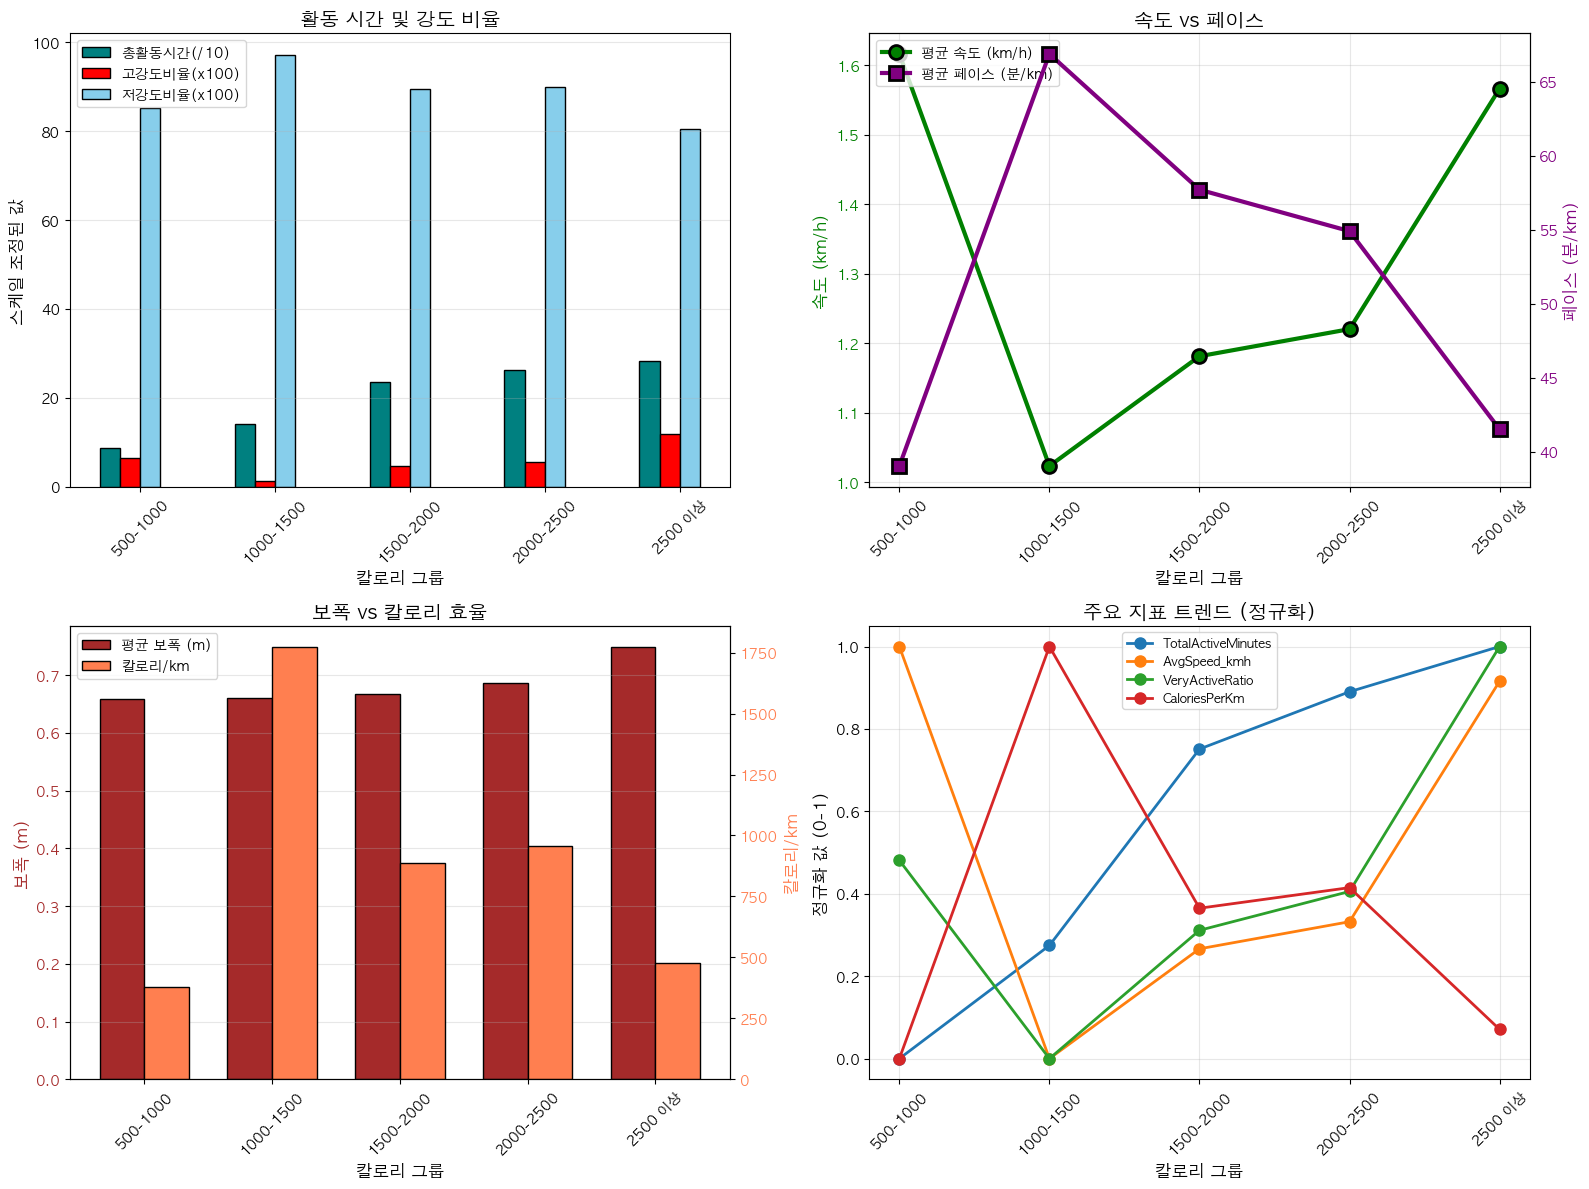

In [116]:
# 5. 그룹화된 비교 (관련 변수끼리)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5-1. 활동 시간 & 비율
ax = axes[0, 0]
x = np.arange(len(calorie_group_derived))
width = 0.15

ax.bar(x - width*1.5, calorie_group_derived['TotalActiveMinutes']/10, 
       width, label='총활동시간(/10)', color='teal', edgecolor='black')
ax.bar(x - width*0.5, calorie_group_derived['VeryActiveRatio']*100, 
       width, label='고강도비율(x100)', color='red', edgecolor='black')
ax.bar(x + width*0.5, calorie_group_derived['LightActiveRatio']*100, 
       width, label='저강도비율(x100)', color='skyblue', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('스케일 조정된 값', fontsize=12)
ax.set_title('활동 시간 및 강도 비율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5-2. 속도 & 페이스
ax = axes[0, 1]
ax2 = ax.twinx()

line1 = ax.plot(calorie_group_derived['AvgSpeed_kmh'], 
                marker='o', linewidth=3, markersize=10, 
                color='green', label='평균 속도 (km/h)', markeredgecolor='black', markeredgewidth=2)
line2 = ax2.plot(calorie_group_derived['AvgPace_min_per_km'], 
                 marker='s', linewidth=3, markersize=10, 
                 color='purple', label='평균 페이스 (분/km)', markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('속도 (km/h)', fontsize=12, color='green')
ax2.set_ylabel('페이스 (분/km)', fontsize=12, color='purple')
ax.set_title('속도 vs 페이스', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='purple')
ax.grid(True, alpha=0.3)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

# 5-3. 보폭 & 칼로리 효율
ax = axes[1, 0]
x = np.arange(len(calorie_group_derived))
width = 0.35

bars1 = ax.bar(x - width/2, calorie_group_derived['AvgStride_m'], 
               width, label='평균 보폭 (m)', color='brown', edgecolor='black')
ax2 = ax.twinx()
bars2 = ax2.bar(x + width/2, calorie_group_derived['CaloriesPerKm'], 
                width, label='칼로리/km', color='coral', edgecolor='black')

ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('보폭 (m)', fontsize=12, color='brown')
ax2.set_ylabel('칼로리/km', fontsize=12, color='coral')
ax.set_title('보폭 vs 칼로리 효율', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.tick_params(axis='y', labelcolor='brown')
ax2.tick_params(axis='y', labelcolor='coral')
ax.grid(True, alpha=0.3, axis='y')

lines = [bars1, bars2]
labels = ['평균 보폭 (m)', '칼로리/km']
ax.legend(lines, labels, loc='upper left')

# 5-4. 종합 비교 (정규화)
ax = axes[1, 1]
calorie_group_derived_normalized[['TotalActiveMinutes', 'AvgSpeed_kmh', 
                                   'VeryActiveRatio', 'CaloriesPerKm']].plot(
    kind='line', marker='o', linewidth=2, markersize=8, ax=ax
)
ax.set_xlabel('칼로리 그룹', fontsize=12)
ax.set_ylabel('정규화 값 (0-1)', fontsize=12)
ax.set_title('주요 지표 트렌드 (정규화)', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(calorie_group_derived)))
ax.set_xticklabels(calorie_group_derived.index, rotation=45)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

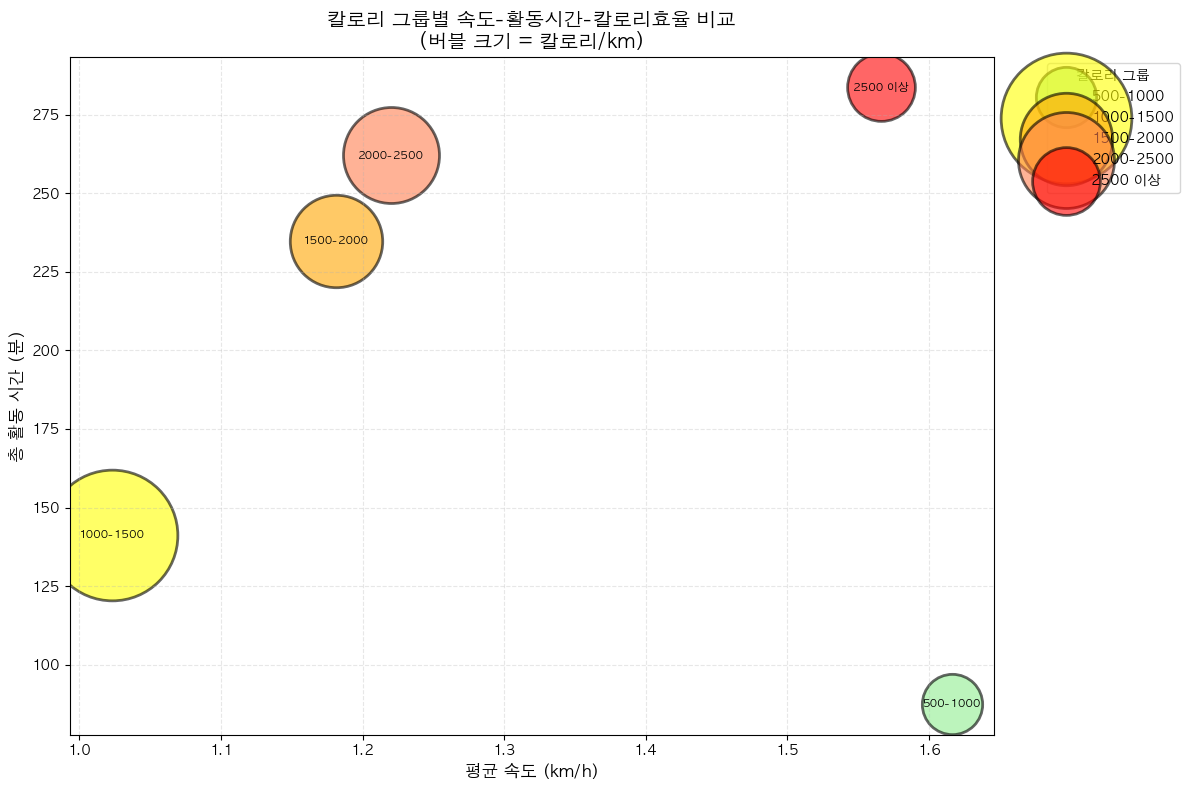

In [117]:
# 6. 버블 차트 (3개 변수 동시 비교)
plt.figure(figsize=(12, 8))

colors_map = {'500 이하': 'lightblue', '500-1000': 'lightgreen', 
              '1000-1500': 'yellow', '1500-2000': 'orange', 
              '2000-2500': 'coral', '2500 이상': 'red'}

for group in calorie_group_derived.index:
    plt.scatter(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
                calorie_group_derived.loc[group, 'TotalActiveMinutes'],
                s=calorie_group_derived.loc[group, 'CaloriesPerKm']*5,
                c=colors_map[group],
                alpha=0.6,
                edgecolors='black',
                linewidth=2,
                label=group)
    
    plt.text(calorie_group_derived.loc[group, 'AvgSpeed_kmh'],
             calorie_group_derived.loc[group, 'TotalActiveMinutes'],
             group, ha='center', va='center', fontsize=8, fontweight='bold')

plt.xlabel('평균 속도 (km/h)', fontsize=12)
plt.ylabel('총 활동 시간 (분)', fontsize=12)
plt.title('칼로리 그룹별 속도-활동시간-칼로리효율 비교\n(버블 크기 = 칼로리/km)', 
          fontsize=14, fontweight='bold')
plt.legend(title='칼로리 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()